# Applying a DAS response to a synthetic seismic gather

Here, I show how a DAS response can be applied to a particle velocity gather created by finite-difference modeling. I use a Marmousi model with a surface seismic geometry. <br> <br>
The theory for this can be found in the following papers  
1) Elastic full-waveform inversion of vertical seismic profile data acquired with distributed acoustic sensors. Anton Egorov, Julia Correa, Andrej Bóna, Roman Pevzner, Konstantin Tertyshnikov, Stanislav Glubokovskikh, Vladimir Puzyrev, and Boris Gurevich,GEOPHYSICS 2018 83:3, R273-R281, doi: [10.1190/geo2017-0718.1](https://library.seg.org/doi/10.1190/geo2017-0718.1) <br>
2) Dean, T. , Cuny, T. and Hartog, A. H. (2017), The effect of gauge length on axially incident P‐waves measured using fibre optic distributed vibration sensing. Geophysical Prospecting, 65: 184-193. doi:[10.1111/1365-2478.12419](https://onlinelibrary.wiley.com/doi/abs/10.1111/1365-2478.12419)

The response can be written in the wavenumber-domain as follows: <br><br>
        <center>$DAS(k_z) = V(k_z)\frac{4sin(\frac{k_zL}{2})sin(\frac{k_zG}{2})}{jk_z}$ </center><br><br>
where $DAS(k_z)$ is the DAS gather, $V(k_z)$ is the particle-velocity-along-the-fiber gather, $L$ is the pulse width in m, $G$ is the gauge length in m, $k_z$ is the wavenumber along the DAS cable.

Note that this occurs in vertical wavenumber domain, i.e. we perform a Fourier transform along the trace axis and then apply this we filter, time-slice by time-slice.

First, all the libraries:

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import m8r

Then, we load a seismic gather. Note that this gather needs to be a particle velocity gather along the fiber, i.e. in this case it will be a horizontal component from surface receivers. Gauge length and pulse width are the input parameters.

In [24]:
fname = 'dat_T_vx.rsf'
G = 10
L = 5

Here, the file input occurs.

In [25]:
inp  = m8r.File(fname)

dt = inp.float('d1')
dtr = inp.float('d2')

ntr,nt = inp.shape()
gath=inp[:]

T = np.arange(0,nt*dt,dt)
X = np.arange(0,ntr*dtr,dt)

Followed by a Fourier transform along the trace axis

In [26]:
gathfft = np.fft.rfft(gath,axis=0)
k = np.fft.rfftfreq(ntr,d=dtr*1000)

The filter is written as follows

In [27]:
kzpi = 2*np.pi*k
flt = 4*np.sin(kzpi*L/2)*np.sin(kzpi*G/2)/1j/kzpi
flt[0]=0.0

/home/anton/anaconda2/envs/Py_Seis/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


Here is the plot of the amplitude response of the filter. Note the notch at $0.1$ cycle/m - this is where the $sin(\frac{k_zG}{2})$ becomes $0$

Text(0,0.5,'A')

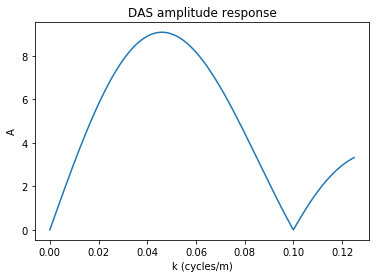

In [28]:
plt.figure()
plt.plot(k,np.abs(flt))
plt.title('DAS amplitude response')
plt.xlabel('k (cycles/m)')
plt.ylabel('A')

Here, we apply the filter. We still process this time-slice by time-slice, but we can do it easily in one line thanks to numpy broadcasting.

In [29]:
procfft = gathfft.T*flt
procfft = procfft.T
gath_proc = np.fft.irfft(procfft,axis=0,n=ntr)

Now, we can compare the gathers in the "wavenumber-along-the-fiber" domain before and after the transformation

Text(0.5,1,'DAS gather, Fourier transform along depth axis')

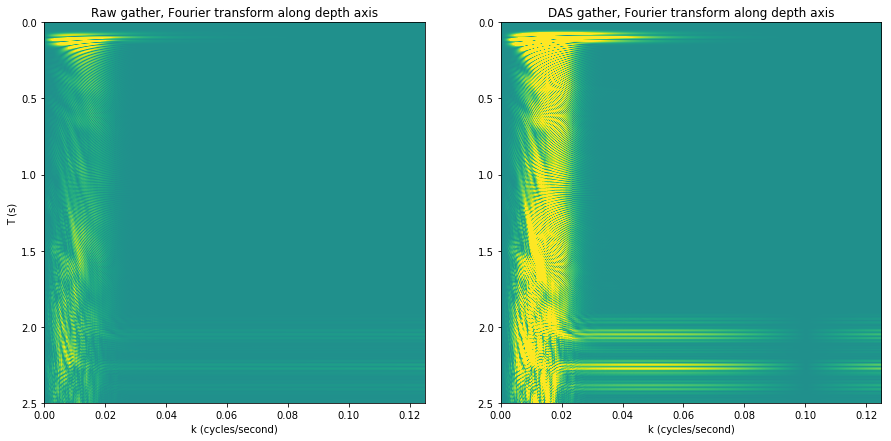

In [31]:
gain = 2000000.0
spec_extent = (k[0],k[-1],T[-1],T[0])

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(np.abs(gathfft).T,aspect='auto',cmap = plt.get_cmap('viridis'),vmin = -1/gain,vmax = 1/gain,extent = spec_extent)
plt.title('Raw gather, Fourier transform along depth axis')
plt.ylabel('T (s)')
plt.xlabel('k (cycles/second)')
plt.subplot(1,2,2)
plt.imshow(np.abs(procfft).T,aspect='auto',cmap = plt.get_cmap('viridis'),vmin = -1/gain,vmax = 1/gain,extent = spec_extent)
plt.xlabel('k (cycles/second)')
plt.title('DAS gather, Fourier transform along depth axis')


In the time domain, the gathers before and after the transformation look as follows. Note how the normal-incidence reflections get attenuated and the events travelling along the fiber are amplified due to DAS directivity. 

Text(0.5,0,'X (km)')

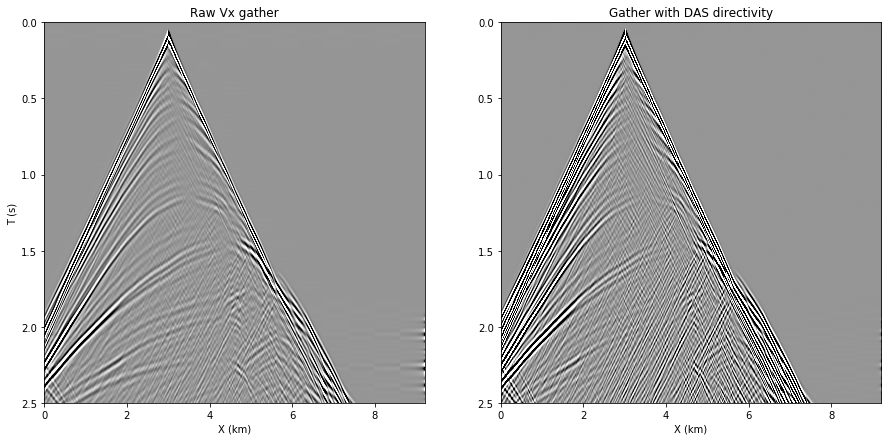

In [33]:
gain = 300000000.0
gain_DAS = 300000000.0

gath_extent = (X[0],X[-1],T[-1],T[0])

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(gath.T,aspect='auto',cmap = plt.get_cmap('Greys'),vmin = -1/gain,vmax = 1/gain,extent = gath_extent)
plt.title('Raw Vx gather')
plt.ylabel('T (s)')
plt.xlabel('X (km)')
plt.subplot(1,2,2)
plt.imshow(gath_proc.T,aspect='auto',cmap = plt.get_cmap('Greys'),vmin = -1/gain_DAS,vmax = 1/gain_DAS,extent = gath_extent)
plt.title('Gather with DAS directivity')
plt.xlabel('X (km)')